In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import pickle

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import auc, roc_curve, roc_auc_score, f1_score, precision_recall_curve, accuracy_score, recall_score,  precision_score
from sklearn import preprocessing


import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# read training data
MHCCBM_results_df = pd.read_csv('./results/MHCCBM_predictions.csv', index_col=0)
MHCCBM_results_df

,peptide,allele,PG_proba,TAP_proba,BA_proba,TD_proba,PS_proba,PS_y,hit,MHCCBM_proba,MHCCBM_y
0,QLEDEALKY,HLA-C*07:01,0.145252,0.8509,0.249647,0.000634,0.045293,0,1,0.036512,0
1,ANLPNQVHRK,HLA-C*07:01,0.027406,0.4082,0.125086,0.000634,0.008373,0,1,0.007461,0
2,AVQELLPQY,HLA-C*07:01,0.607908,0.8152,0.343496,0.000634,0.395328,0,1,0.336029,0
3,NRLYPVSAR,HLA-C*07:01,0.754642,0.9378,0.442899,0.000634,0.757477,1,1,0.699637,1
4,RIADISQVY,HLA-C*07:01,0.961274,0.7269,0.551362,0.000634,0.953020,1,1,0.940063,1
...,...,...,...,...,...,...,...,...,...,...,...
2673613,QAESENLLD,HLA-C*08:02,0.001002,0.6163,0.078606,0.003754,0.004696,0,0,0.003989,0
2673614,DIERMVQEA,HLA-C*08:02,0.049257,0.0859,0.107641,0.003754,0.007537,0,0,0.007231,0
2673615,KLVRSVTVV,HLA-C*08:02,0.205821,0.2838,0.129008,0.003754,0.016273,0,0,0.014710,0
2673616,DAEVLTAVLM,HLA-C*08:02,0.025275,0.3686,0.100851,0.003754,0.006454,0,0,0.005806,0


## EDA

<AxesSubplot: xlabel='hit', ylabel='TAP_proba'>

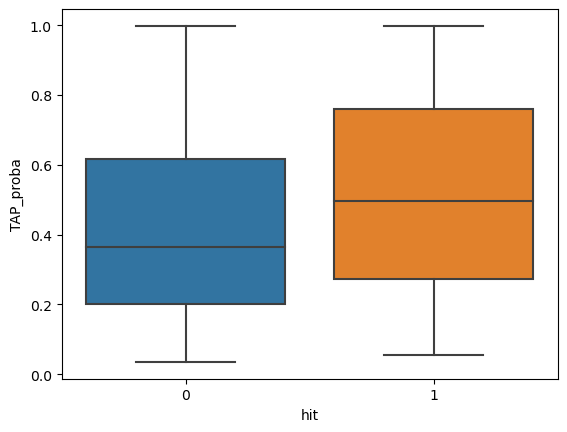

In [41]:
sns.boxplot(data=MHCCBM_results_df,  y='TAP_proba', x='hit')

<AxesSubplot: xlabel='MHCCBM_y', ylabel='TAP_proba'>

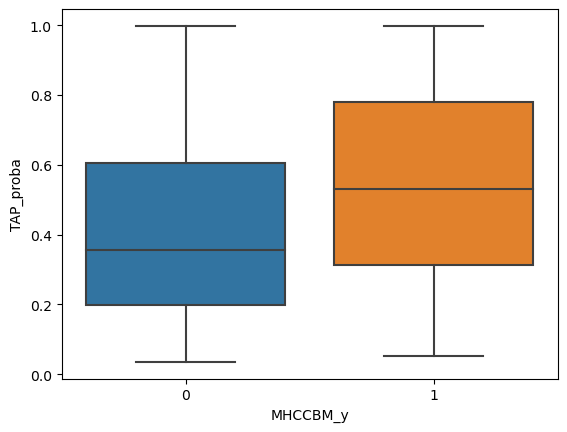

In [43]:
sns.boxplot(data=MHCCBM_results_df,  y='TAP_proba', x='MHCCBM_y')

## Results

In [3]:
# how many samples were correctly predicted 
nsamples = len(MHCCBM_results_df[(MHCCBM_results_df['MHCCBM_y']!=MHCCBM_results_df['PS_y'])
                            &(MHCCBM_results_df['MHCCBM_y']==MHCCBM_results_df['hit'])])
print("MHCCBM correctly predicted but PS predictor got wrong: ", nsamples)

nsamples = len(MHCCBM_results_df[(MHCCBM_results_df['MHCCBM_y']!=MHCCBM_results_df['PS_y'])
                            &(MHCCBM_results_df['PS_y']==MHCCBM_results_df['hit'])])
print("PS predictor correctly predicted but MHCCBM got wrong: ", nsamples)


# How many were predicted incorrectly
nsamples = len(MHCCBM_results_df[MHCCBM_results_df['MHCCBM_y']!=MHCCBM_results_df['hit']])
print("MHCCBM incorrect predictions: ", nsamples)

nsamples = len(MHCCBM_results_df[MHCCBM_results_df['PS_y']!=MHCCBM_results_df['hit']])
print("PS predictor incorrect predictions: ", nsamples)

MHCCBM correctly predicted but PS predictor got wrong:  11331
PS predictor correctly predicted but MHCCBM got wrong:  1080
MHCCBM incorrect predictions:  132737
PS predictor incorrect predictions:  142988


In [4]:
# split into hits and non  hits
MHCCBM_results_df = MHCCBM_results_df[(MHCCBM_results_df['MHCCBM_y']!=MHCCBM_results_df['PS_y'])&(MHCCBM_results_df['MHCCBM_y']==MHCCBM_results_df['hit'])]
MHCCBM_results_1df = MHCCBM_results_df[MHCCBM_results_df['hit']==1]
MHCCBM_results_0df = MHCCBM_results_df[MHCCBM_results_df['hit']==0]
print("MHCCBM_results_1df: ", len(MHCCBM_results_1df))
print("MHCCBM_results_0df: ", len(MHCCBM_results_0df))
MHCCBM_results_df

MHCCBM_results_1df:  4
MHCCBM_results_0df:  11327


,peptide,allele,PG_proba,TAP_proba,BA_proba,TD_proba,PS_proba,PS_y,hit,MHCCBM_proba,MHCCBM_y
190,PRIGYGLLL,HLA-C*07:01,0.124034,0.7670,0.560111,0.000634,0.534845,1,0,0.488972,0
206,YGDGYRMAF,HLA-C*07:01,0.152453,0.7220,0.549020,0.000634,0.530858,1,0,0.486753,0
323,RRLSTPPSSNV,HLA-C*07:01,0.053710,0.8836,0.574690,0.000634,0.511001,1,0,0.460237,0
644,SRADGRKF,HLA-C*07:01,0.015536,0.7419,0.587032,0.000634,0.509663,1,0,0.468342,0
726,KRSGKLDAFL,HLA-C*07:01,0.011442,0.9667,0.595926,0.000634,0.529379,1,0,0.475051,0
...,...,...,...,...,...,...,...,...,...,...,...
2672627,AQDGVINEEAL,HLA-C*08:02,0.228501,0.5194,0.515819,0.003754,0.510928,1,0,0.476799,0
2672704,TLDFCRRL,HLA-C*08:02,0.068437,0.8299,0.570297,0.003754,0.512485,1,0,0.464869,0
2673051,KAELLSLKL,HLA-C*08:02,0.042673,0.7715,0.578216,0.003754,0.510503,1,0,0.467075,0
2673172,STEENSLSHL,HLA-C*08:02,0.136659,0.7026,0.545008,0.003754,0.506386,1,0,0.464208,0


In [2]:
# weights and bias of clf
wt_ls = np.array([ 3.4396314 , -0.2358465 , 10.57130895,  0.56121568])
bias = np.array([-6.2113177])

In [36]:
# with hit
# With non hit
idx = 0
sample_X = MHCCBM_results_1df[['PG_proba','TAP_proba','BA_proba','TD_proba']].iloc[idx].to_numpy()
print("original: ", 1/(1+np.exp(-np.sum(sample_X*wt_ls)-bias)))

for i in range(len(sample_X)):
    sample_X_ = sample_X.copy()
    sample_X_[i] = 0
    print(1/(1+np.exp(-np.sum(sample_X_*wt_ls)-bias)))
    
MHCCBM_results_1df.iloc[idx:idx+1]

original:  [0.57912828]
[0.17356188]
[0.61660462]
[0.01933563]
[0.43978867]


,peptide,allele,PG_proba,TAP_proba,BA_proba,TD_proba,PS_proba,PS_y,hit,MHCCBM_proba,MHCCBM_y
2139231,TQDENPVVHFF,HLA-B*44:02,0.546508,0.6613,0.401604,1.0,0.492123,0,1,0.579128,1


In [35]:
# With non hit
idx = 0
sample_X = MHCCBM_results_0df[['PG_proba','TAP_proba','BA_proba','TD_proba']].iloc[idx].to_numpy()
print("original: ", 1/(1+np.exp(-np.sum(sample_X*wt_ls)-bias)))

for i in range(len(sample_X)):
    sample_X_ = sample_X.copy()
    sample_X_[i] = 0
    print(1/(1+np.exp(-np.sum(sample_X_*wt_ls)-bias)))
    
MHCCBM_results_0df.iloc[idx:idx+1]

original:  [0.48897202]
[0.38443867]
[0.53414059]
[0.0025599]
[0.48888304]


,peptide,allele,PG_proba,TAP_proba,BA_proba,TD_proba,PS_proba,PS_y,hit,MHCCBM_proba,MHCCBM_y
190,PRIGYGLLL,HLA-C*07:01,0.124034,0.767,0.560111,0.000634,0.534845,1,0,0.488972,0


In [52]:
PT_df = pd.read_csv('./results/PS_peptides_DeepTAP_cla_predresult.csv')
PT_df[PT_df['peptide'].isin(MHCCBM_results_0df['peptide'])]

,peptide,pred_score,pred_label
450,VHDNKVLRI,0.3242,0
697,GQASGELLQQI,0.3861,0
914,HSTVGLAQQW,0.3531,0
1235,VERAQINSF,0.3045,0
2250,APRNESNNL,0.3235,0
...,...,...,...
66985,STDGKHWWEY,0.9784,1
67916,YVMYYEMSY,0.7807,1
68253,ALNLDTSKF,0.8249,1
68762,LENIKRKV,0.2242,0
